# FSA and fungal trait analysis

**Project summary**: We aim to understand if there is a correlation between the presence of FSA in Fungi and different curated fungal traits. 
For 210 fungal species, we have curated information about the presence/absence of FSA, phylogenetic relationship as well as at least 1 fungal per species. The traits include discrete traits such as ecological information (trophic mode, growth form, guild, sterol type, presence/absence of specific genes, reproductive strucure information) as well as continuous traits (gene counts, composition (melanin content, carbon content, nitrogen content and phosphorus content))

**Aim**: the aim of this project is to use different models, accounting or not for the data nonindependence (phylogentic relationship), to test any correlation between FSA and some of these traits.In other words, we are modeling if the fungal trait we have curated could be predictor of the FSA staus in fungal species.

**Strategy**: The variable we are testing is the presence/absence of FSA in fungal species, this is thus a binomial variable. Depending on the trait we are investigating, we are then trying to predict a binary variable with either a continuous or a discrete predictor (for now, we are focusing on prediction by a single trait and not combination of traits yet). We are considering the following models:

   *Continuous predictor*:
   
            - Logistic regression (not accounting for data nonindependency)
            - Phylogentic logistic regression (accounting for data nonidenpendency)
            - Other potential model: pglmm
    
   *Discrete predictor*:
 
            - Fisher exact test or Chi2 depending on sample size (not accounting for data nonindependency)
            - Potential model accounting for nonindependency: pglmm

**Notebook description**: this specific notebook focuses on the testing of continuous trait as predictors of FSA status using Logistic Regression (LR) and Phylogenetic Logistic Regression (PLR)


------------------------------------------------------------------------------------------------------------------

## Environment setup

In [1]:
library(ggtree)
library(phylolm)
library(ggplot2)
library(ggVennDiagram)
library(stringr)

ggtree v3.6.0 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in published research, please cite
the appropriate paper(s):

Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
ggtree: an R package for visualization and annotation of phylogenetic
trees with their covariates and other associated data. Methods in
Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628

Shuangbin Xu, Lin Li, Xiao Luo, Meijun Chen, Wenli Tang, Li Zhan, Zehan
Dai, Tommy T. Lam, Yi Guan, Guangchuang Yu. Ggtree: A serialized data
object for visualization of a phylogenetic tree and annotation data.
iMeta 2022, 4(1):e56. doi:10.1002/imt2.56

Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods
for mapping and visualizing associated data on phylogeny using ggtree.
Molecular Biology and Evolution. 2018, 35(12):3041-3043.
doi:10.1093/molbev/msy194 

Warning message:
“package ‘phylolm’ was built under R version 4.2.3”
Loading requir

## Functions definition

In [3]:
# This function allows to do the LR for a chosen trait
# Using a trait information table + trait of interest as input value, this function returns the LR model output

LR_model_Ctrait=function(data,trait){
    
    # data prep/formating for model
    rownames(data)=data$tip.label
    posit=which(colnames(data)==trait)
    data_trait_temp=data[,c(2,posit)]
    data_trait=na.omit(data_trait_temp)
    colnames(data_trait)=c('FSA',"Trait")
    
    # model

    model_lr=glm(FSA~Trait,data=data_trait,
                  family='binomial')
    
    out=model_lr
    
    out
    
}



# This function allows to do the PLR for a chosen trait
# Using a trait information table + tree + trait of interest as input value, this function returns the PLR model output

PLR_model_Ctrait=function(data,tree,trait){
    
    # data prep/formating for model
    rownames(data)=data$tip.label
    posit=which(colnames(data)==trait)
    data_trait_temp=data[,c(2,posit)]
    data_trait=na.omit(data_trait_temp)
    colnames(data_trait)=c('FSA',"Trait")
    
    # tree pruning: keep only branches for the species that have trait information
    
    tip_tree=rownames(data_trait)
    tree_trait=keep.tip(tree,tip_tree)
    
    # model
    # using the phyloglm function from the phylolm R package with the method 'logistic_MPLE' that maximizes the penalized likelihood of the logistic regression
    # using a maximum boostrap of 100 and btol(bound for the linear predictor to bound the searching space) of 10

    model_plr=phyloglm(FSA~Trait, data_trait, tree_trait, 
                    method = c("logistic_MPLE"),boot=100,btol=10)
    
    out=model_plr
    
    out
    
}

# This function allows to do the PLR for a chosen trait using this time the logistic_IG10 family method
# Using a trait information table + trait of interest as input value, this function returns (i) the LR model, (ii) the summary of the LR model, and (iii) the coefficients table - all stored in a list

PLR_model_Ctrait_IG10=function(data,tree,trait){
    
    # data prep/formating for model
    rownames(data)=data$tip.label
    posit=which(colnames(data)==trait)
    data_trait_temp=data[,c(2,posit)]
    data_trait=na.omit(data_trait_temp)
    colnames(data_trait)=c('FSA',"Trait")
    
    # tree pruning: keep only branches for the species that have trait information
    
    tip_tree=rownames(data_trait)
    tree_trait=keep.tip(tree,tip_tree)
    
    # model
    # using the phyloglm function from the phylolm R package with the method 'logistic_IG10' that optimizes a GEE (generalized estimating equation) approximation to the penalized likelihood
    # using a maximum boostrap of 100 and btol(bound for the linear predictor to bound the searching space) of 10

    model_plr=phyloglm(FSA~Trait, data_trait, tree_trait, 
                    method = c("logistic_IG10"),boot=100,btol=10)
    
    out=model_plr
    
    out
    
}


# This function reformat and summarizes the output of the models into a dataframe when models have been run in a loop and stored in a list
# Using a trait information table + trait of interest as input value, this function returns (i) the LR model, (ii) the summary of the LR model, and (iii) the coefficients table - all stored in a list

model_result_sum_table=function(multiple_model_output){

    df_results_model=data.frame()
    for (i in 1:length(multiple_model_output)){

      trait_t=names(multiple_model_output[i])
      res_1=multiple_model_output[[i]]
      sum_1=summary(res_1)
      AIC_t=sum_1$aic
      coef_1=sum_1$coefficients
  
      if (length(grep('_ plr',trait_t))==1) {           
        mod_t='PLR MPLE'
        interc=coef_1['(Intercept)','Estimate']
        slope=coef_1['Trait','Estimate']
    
        pv_interc=coef_1['(Intercept)','p.value']
        pv_slope=coef_1['Trait','p.value']
          
          if (length(grep('plr_IG10',trait_t))==1){
              mod_t='PLR IG10'
          }
  
      } else {
        mod_t='LR'
        interc=coef_1['(Intercept)','Estimate']
        slope=coef_1['Trait','Estimate']
  
        pv_interc=coef_1['(Intercept)','Pr(>|z|)']
        pv_slope=coef_1['Trait','Pr(>|z|)']
    
        
          
      }
  
      df_temp=data.frame('trait'=trait_t,
                     'model'=mod_t,
                     'intercept'=interc,
                     'pval_interp'=pv_interc,
                     'slope'=slope,
                     'pval_slope'=pv_slope,
                     'AIC'=AIC_t)
  
      df_results_model=rbind(df_results_model, df_temp)
    }

    df_results_model
}





## Data import

In [4]:
tree=read.tree('tree_for_trait_210.nwk') #phylogenetic tree that contains phylogenetic relationships for al 210 species

data=read.csv('data_continuous_traits_210.csv') #trait information for all 210 species for the continuous traits


## Running models for each trait

We run the test only for the traits for which we see a diversity in the distribution of presence/absence of FSA within the species that have the trait information. Our decision rule is that if 90% or more of the species have the same FSA status, we don't have any information to conduct a relevent test for the association of FSA and a trait. For exemple: for the trait 'trehalase_count', 113 species have the trait information and 60 of them possess FSA while 53 don't - this is a good context to run the test. On the contrary, for the trait 'acid_phosphatase' that measures enzymatic activity, 16 species have the trait information while 15 of them possess an FSA; as this represent most of the population it doesn't seem relevent to test if this enzymatic activity is a predictor of the FSA status

The traits we run the models for are:
     
     - 31 gene counts (acidPhosphatase_count, alpha_Glucosidase15_count, alpha_Glucosidase31_count, alphaManNAase76_count, aminoAcidPermease_count, ammoniumTransporter_count, amylase88_count, aucinResponsivePromoter_count, betaGlucanSynthase_count, betaGlucosidase1_count, betaXylosidase43_count, cellobiohydrolase6_count, cellobiohydrolase7_count, chitinase_count, chitosanase8_count, coldShockProtein_count, crystalineCellulaseAA9_count, endoglucanase12_count, endoglucanase9_count, fungalLigninPeroxidase_count, glucosidase81_count, glycopeptidase85_count, glycoproteinSynthesis92_count, heatShockProtein_count, invertase32_count, melanin_count, nitrateTransporter_count, phosphateTransporter_count, RNAHelicase_count, RNApolymerase_count, trehalase_count) ; 113 species (60 with FSA)
    - extension rate (extension_rate) ; 13 species (8 with FSA)
    - Spore data (spore_size, spore_length, spore_width, fruiting_body_size) ; 17 species (14 with FSA)
    - melanin content (melanin_content) ; 24 species (17 with FSA)
    - Tissue carbon content (tissue_c) ; 50 species (29 with FSA)
    - Tissue nitrogen content (tissue_n) ; 31 species (19 with FSA)
    - Tissue phosphorus content (tissue_p) ; 39 species (21 with FSA)
    
 *Note*: for less that 20 species, the power for applying any phylogentic analysis is probably too low and regular LR model should be enough

In [99]:
# Extension rate
ExR_lr=LR_model_Ctrait(data,'extension_rate')
ExR_plr=PLR_model_Ctrait(data,tree,'extension_rate')
ExR_plrIG10=PLR_model_Ctrait_IG10(data,tree,'extension_rate')

ExR_results=list(ExR_lr,ExR_plr,ExR_plrIG10)
names(ExR_results)=c("ExtR _ lr","ExtR _ plr","ExtR _ plr _ IG10")

# Melanin content
Mel_lr=LR_model_Ctrait(data,'melanin_content')
Mel_plr=PLR_model_Ctrait(data,tree,'melanin_content')
Mel_plrIG10=PLR_model_Ctrait_IG10(data,tree,'melanin_content')

Mel_results=list(Mel_lr, Mel_plr, Mel_plrIG10)
names(Mel_results)=c("Mel _ lr","Mel _ plr","Mel _ plr _ IG10")

# Tissue - carbon content
TisC_lr=LR_model_Ctrait(data,'tissue_c')
TisC_plr=PLR_model_Ctrait(data,tree,'tissue_c')
TisC_plrIG10=PLR_model_Ctrait_IG10(data,tree,'tissue_c')


TisC_results=list(TisC_lr, TisC_plr, TisC_plrIG10)
names(TisC_results)=c("TisC _ lr","TisC _ plr","TisC _ plr _ IG10")

# Tissue - nitrogen content
TisN_lr=LR_model_Ctrait(data,'tissue_n')
TisN_plr=PLR_model_Ctrait(data,tree,'tissue_n')
TisN_plrIG10=PLR_model_Ctrait_IG10(data,tree,'tissue_n')

TisN_results=list(TisN_lr, TisN_plr, TisN_plrIG10)
names(TisN_results)=c("TisN _ lr","TisN _ plr","TisN _ plr _ IG10")


# Tissue - phosphorus content
TisP_lr=LR_model_Ctrait(data,'tissue_p')
TisP_plr=PLR_model_Ctrait(data,tree,'tissue_p')
TisP_plrIG10=PLR_model_Ctrait_IG10(data,tree,'tissue_p')

TisP_results=list(TisP_lr, TisP_plr, TisP_plrIG10)
names(TisP_results)=c("TisP _ lr","TisP _ plr","TisP _ plr _ IG10")


Warning message in phyloglm(FSA ~ Trait, data_trait, tree_trait, method = c("logistic_MPLE"), :
“the boundary of the linear predictor has been reached during the optimization procedure.
You can increase this bound by increasing 'btol'.”
Warning message in phyloglm(FSA ~ Trait, data_trait, tree_trait, method = c("logistic_IG10"), :
“the estimate of 'alpha' (0.0804863049430777) reached the upper bound (0.0808626010078372).
 This may simply reflect a flat likelihood at large alpha values,
 meaning that the phylogenetic correlation is estimated to be negligible.”
Warning message in phyloglm(FSA ~ Trait, data_trait, tree_trait, method = c("logistic_IG10"), :
“the boundary of the linear predictor has been reached during the optimization procedure.
You can increase this bound by increasing 'btol'.”
Warning message in phyloglm(FSA ~ Trait, data_trait, tree_trait, method = c("logistic_MPLE"), :
“the boundary of the linear predictor has been reached during the optimization procedure.
You can inc

In [118]:
ExR_results=list(ExR_lr,ExR_plr,ExR_plrIG10)
names(ExR_results)=c("ExtR _ lr","ExtR _ plr","ExtR _ plr_IG10")

Mel_results=list(Mel_lr, Mel_plr, Mel_plrIG10)
names(Mel_results)=c("Mel _ lr","Mel _ plr","Mel _ plr_IG10")

TisC_results=list(TisC_lr, TisC_plr, TisC_plrIG10)
names(TisC_results)=c("TisC _ lr","TisC _ plr","TisC _ plr_IG10")

TisN_results=list(TisN_lr, TisN_plr, TisN_plrIG10)
names(TisN_results)=c("TisN _ lr","TisN _ plr","TisN _ plr_IG10")

TisP_results=list(TisP_lr, TisP_plr, TisP_plrIG10)
names(TisP_results)=c("TisP _ lr","TisP _ plr","TisP _ plr_IG10")

In [111]:
#Spore data

trait_spore=c('spore_size', 'spore_length', 'spore_width', 'fruiting_body_size')

results_spore_traits=list()

for (i in 1:length(trait_spore)){
    trait=trait_spore[i]
    lr_mod=LR_model_Ctrait(data,trait)
    plr_mod=PLR_model_Ctrait(data,tree,trait)
    plr_mod_IG10=PLR_model_Ctrait_IG10(data,tree,trait)
    
    vec=list(lr_mod,plr_mod,plr_mod_IG10)
    names(vec)=c(paste(trait,"_","lr"),paste(trait,"_","plr"),paste(trait,"_","plr_IG10"))
    
    results_spore_traits=c(results_spore_traits,vec)
}



Warning message in phyloglm(FSA ~ Trait, data_trait, tree_trait, method = c("logistic_MPLE"), :
“the estimate of 'alpha' (0.0841272993125161) reached the upper bound (0.0845089400380152).
 This may simply reflect a flat likelihood at large alpha values,
 meaning that the phylogenetic correlation is estimated to be negligible.”
Warning message in phyloglm(FSA ~ Trait, data_trait, tree_trait, method = c("logistic_MPLE"), :
“the boundary of the linear predictor has been reached during the optimization procedure.
You can increase this bound by increasing 'btol'.”
Warning message in phyloglm(FSA ~ Trait, data_trait, tree_trait, method = c("logistic_MPLE"), :
“phyloglm failed to converge.
”
Warning message in phyloglm(FSA ~ Trait, data_trait, tree_trait, method = c("logistic_IG10"), :
“the boundary of the linear predictor has been reached during the optimization procedure.
You can increase this bound by increasing 'btol'.”
Warning message in phyloglm(FSA ~ Trait, data_trait, tree_trait, meth

In [5]:
# Gene count

trait_gene=c('acidPhosphatase_count', 'alphaGlucosidase15_count', 'alphaGlucosidase31_count', 'alphaManNAase76_count', 'aminoAcidPermease_count',
             'ammoniumTransporter_count', 'amylase88_count', 'auxinResponsivePromoter_count', 'betaGlucanSynthase_count', 'betaGlucosidase1_count',
             'betaXylosidase43_count', 'cellobiohydrolase6_count', 'cellobiohydrolase7_count', 'chitinase_count', 'chitosanase8_count', 
             'coldShockProtein_count', 'crystalineCellulaseAA9_count', 'endoglucanase12_count', 'endoglucanase9_count', 'fungalLigninPeroxidase_count',
             'glucosidase81_count', 'glycopeptidase85_count', 'glycoproteinSynthesis92_count', 'heatShockProtein_count', 'invertase32_count', 
             'melanin_count', 'nitrateTransporter_count', 'phosphateTransporter_count', 'RNAHelicase_count', 'RNApolymerase_count', 'trehalase_count')

results_gene_traits=list()

for (i in 1:length(trait_gene)){
    trait=trait_gene[i]
    lr_mod=LR_model_Ctrait(data,trait)
    plr_mod=PLR_model_Ctrait(data,tree,trait)
    plr_mod_IG10=PLR_model_Ctrait_IG10(data,tree,trait)
    
    vec=list(lr_mod,plr_mod,plr_mod_IG10)
    names(vec)=c(paste(trait,"_","lr"),paste(trait,"_","plr"),paste(trait,"_","plr_IG10"))
    
    results_gene_traits=c(results_gene_traits,vec)
}

Warning message in phyloglm(FSA ~ Trait, data_trait, tree_trait, method = c("logistic_MPLE"), :
“the boundary of the linear predictor has been reached during the optimization procedure.
You can increase this bound by increasing 'btol'.”
Warning message in phyloglm(FSA ~ Trait, data_trait, tree_trait, method = c("logistic_IG10"), :
“the estimate of 'alpha' (0.0684310968290302) reached the upper bound (0.0688054688934949).
 This may simply reflect a flat likelihood at large alpha values,
 meaning that the phylogenetic correlation is estimated to be negligible.”
Warning message in phyloglm(FSA ~ Trait, data_trait, tree_trait, method = c("logistic_IG10"), :
“the boundary of the linear predictor has been reached during the optimization procedure.
You can increase this bound by increasing 'btol'.”
Warning message in phyloglm(FSA ~ Trait, data_trait, tree_trait, method = c("logistic_MPLE"), :
“the boundary of the linear predictor has been reached during the optimization procedure.
You can inc

## Results interpretation

### Gene count

To be able to interpret the results, we need to clarify what hypothesis we are testing here and what biological information we will gain from such model.

**Hypothesis**

Running logistic regression on fungal species FSA status using gene copy of a given gene as a predictor, we are testing whether the number of copy of a given gene can be predictive of the FSA status. 
FSA status is a binary value with 0 indicating absence of FSA and 1 presence of FSA. Roughly, for binomial values, a logistic regression first transforms the binary data using the link function logit (whether or not phylogeny has been taken into account) and will determine a linear model that predicts the log odds that a fungal species has a FSA (FSA status of 1) as a function of the number of copies of the given gene

**Interpretation of the coefficients**
The model returns 2 coefficients:
    - the intercept: here corresponds to the log odds of the FSA status to be 1 when there is no copy of the tested gene
    - predictor (gene copy) effect (slope): average increase of the log odds of the FSA status to be 1 when gene copy increases of 1 unit.

1- When none of the coefficient are significant, the model indicates that there is no effect of the predictor (number of gene copy) on the FSA status
2- When the slope is significant, this indicates that the trait is a significant predictor of the response (but potentially can be very weak)

**Biological interpretation of when a gene copy number is a significant predictor of FSA status**

Gene presence can be representative of a given biological function. Gene copy number could potentially indicate if this specific function is important (for instance, you might want to have multiple copies of a gene if this is a very important gene so you have 'rescue' copies) - Depending on the function of the gene, correlation between gene copy number and FSA presence could indicate a correlation between the function or phenotypic trait sustained by that gene and FSA (ex: gene that contributes to a specific trophic mode , or pathogenic state  could highlight that presence of FSA is correlated with a given trophic mode or with pathogenesis respectively).
A similar correlation analysis could be performed using the gene as a discrete predictor using only gene presence/absence information to see if this correlates with FSA status.

**LR and PLR Models goodnessof fit evaluation and comparison**

As we are trying two different regressions for each trait, we eventually want to evaluate and compare how each model (LR versus PLR) performs. Right now, we are using the pergormance metrics: AIC (Akaike's Information Criteria). AIC is an unbiased estimate of the model prediction error MSE- it penalizes the inclusion of additional variables to the model (=> it adds a penalty that increases the error when additional terms are included) - The lower the AIC, the better the model. Other measures such as null deviance and residual deviance could be used if necessary.  

*Notes*:
  - *while gene copy number might not be a predictor, mybe a simple gene presence/absence status could - thus we may also test the presence/absence of these genes as a predictor for FSA status but this will make them discrete data* 
  - *number of gene copy can be affected by genome size - should run similar analysis using copy number/genome size*


In [131]:
df_results_models_gcounts=model_result_sum_table(results_gene_traits)
df_results_models_gcounts

trait,model,intercept,pval_interp,slope,pval_slope,AIC
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
acidPhosphatase_count _ lr,LR,-1.38211200,0.011041847,0.143662924,0.003276142,150.2049
acidPhosphatase_count _ plr,PLR MPLE,-1.08191342,0.104846247,0.204950845,0.004212088,151.4624
acidPhosphatase_count _ plr_IG10,PLR IG10,-1.30600220,0.016705098,0.144938509,0.003486495,156.6356
alphaGlucosidase15_count _ lr,LR,-0.90670222,0.027515151,0.468438034,0.005298175,151.4072
alphaGlucosidase15_count _ plr,PLR MPLE,-0.75539499,0.109957140,0.500289799,0.006567896,161.3597
alphaGlucosidase15_count _ plr_IG10,PLR IG10,-0.77515142,0.061666790,0.443498889,0.008775242,159.7490
alphaGlucosidase31_count _ lr,LR,-0.54532702,0.174496532,0.120434305,0.060230287,156.5464
alphaGlucosidase31_count _ plr,PLR MPLE,-0.43068032,0.486797232,0.221241911,0.011191695,143.9799
alphaGlucosidase31_count _ plr_IG10,PLR IG10,-0.64392131,0.119493861,0.156815689,0.023050542,160.4217


In [132]:
write.csv(df_results_models_gcounts,'gene_counts_models_results_10162023.csv')

#### Data interpretation / summary 

**Coefficient analysis**

Different scenarios are presents in the data:
* models that identified no significant intecept and not significant slope --> the trait is not a predictor of the FSA status
* models that identified significant intercept and significant slope  --> the trait is a predictor of the FSA status
* models that identified significant slope (not significant intercept) --> the trait is a predictor of the FSA status


Here, we did not identified any case where only the intercept was signifcant.

Depending on the gene, LR and PLR models can lead to different conclusion regarding whether or not the gene count is a predictor of the trait. Overall, LR and PLR led to same conclusion for 22 genes and to opposite conclusions for 9 genes. Here is a summary of the different scenarios where LR and PLR lead to similar or differnt outcomes:

<u> No significant slope found from both LR and PLR (both PLR models)</u>

There are 9 genes for which none of the models (LR or PLR) identified a non significant slope.
For these genes, both models agree that the number of copy for these genes is not a predictor for the FSA status. These genes are: auxinResponsivePromoter, betaGlucanSynthase, betaGlucosidase1_count, chitosanase8, coldShockProtein, heatShockProtein_count, melanin_count, RNAHelicase_count and RNApolymerase_count.

Some of these genes are assocaited with response to environmental signals (auxin, cold, heat) and don't seem to be assocaited with FSA presence/absence - RNA helicase and polymerase are essential RNA protein for gene expression and RNA metabolism, different mechanisms/cell events that were unlikely to be associated with FSA. 

<u> Significant slope found from both LR and PLR (at least 1 PLR)</u>

Both LR and PLR models identify a significant slope for 14 different gene, highlighting that the number of copy of these 14 genes is a predictor of the FSA status.
These genes are: acidPhosphatase, alphaGlucosidase15, alphaManNAase76, aminoAcidPermease, amylase88, cellobiohydrolase7, crystalineCellulaseAA9, endoglucanase12, endoglucanase9, fungalLigninPeroxidase, glucosidase81, glycopeptidase85, glycoproteinSynthesis92, and trehalase  

<u> Significant slope found with PLR but not with LR</u>

For 8 genes, taking into account phylogeny (PLR) identified a significant slope highlighting that the gene copy number is a predictor of the FSA status, while regular logistic regression (LR) led to the opposite conclusion.
These genes are:
* alphaGlucosidase31 (PLR_MPLE & PLR_IG10 ; PLR with better AIC)
* ammonium transporter (PLR_MPLE only ; PLR with better AIC)
* beta-xylosidase43 (PLR_MPLE only ; PLR with better AIC)
* cellobiohydrolase6 (PLR_MPLE only ; LR with better AIC)
* chitinase (PLR_MPLE only ; LR with better AIC)
* invertase32 (PLR_MPLE only ; LR with better AIC)
* nitrate transporter (PLR_MPLE & PLM_IG10 ; PLR with better AIC)
* phosphate transporter (PLR_MPLE only ; LR with better AIC)

Yet, for three of these genes, based on AIC values, LR models seem to be a better fit

**Model goodness of fit comparison**

Comparing AIC values for LR and PLR models of the same gene, we can see that PLR are better models for 11 genes. Usually PLR_MPLE have better AIC than PLM_IG10

*Note: could make complementary analysis of AIC difference and see how AIC difference are distributed among different conclusion scenarios (PLR and LR same conclusion versus PLR and LR different conclusion for instance)*


### Overall comparison of the 3 models

We simply investigate:
- how the different models overlap in terms of gene count that are identified as FSA status predictor
- the distribution of pvalue for each models
- the distribution of AIC values

In [2]:
df_results_models_gcounts=read.csv('gene_counts_models_results_10162023.csv')

#### Models overlap

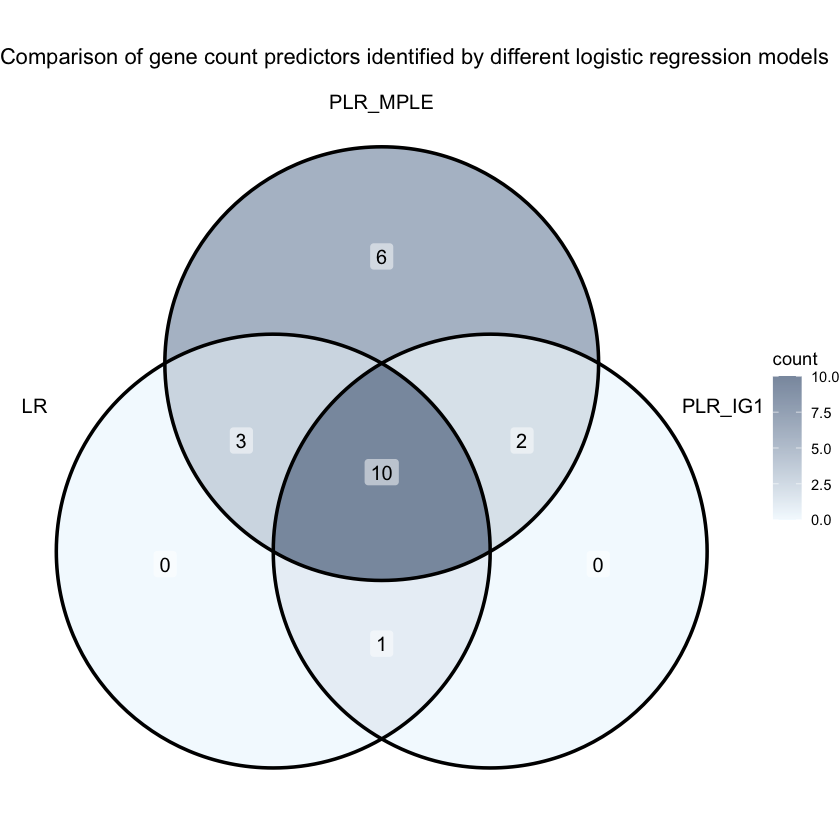

In [5]:
# First look at results overlap
# Visualize whether the models identify similar or different genes as predictor of fsa statuts
# Visualization requires the library ggVennDiagram

data_venn=df_results_models_gcounts
data_venn=data_venn[,-1]
data_venn$gene='gene' # adding a column that contains gene name that will be filled in the for loop

for(i in 1: dim(data_venn)[1]){
  
  gene_cnt=data_venn[i,1]
  gene_split=c(str_split(gene_cnt,'_count'))[[1]] #splitting the trait name to only keep the gene name part and use that in the new gene column
  gene_name=gene_split[[1]]
  
  data_venn[i,8]=gene_name
  
  
}

sig_slopes=subset(data_venn, data_venn$pval_slope<=0.05)  # subset table for only significant pval_slopes (<=0.05)


# creating a subset table for each model type
lr_sig=subset(sig_slopes, sig_slopes$model=='LR')  
plr_mple_sig=subset(sig_slopes, sig_slopes$model=='PLR MPLE')
plr_ig10_sig=subset(sig_slopes, sig_slopes$model=='PLR IG10')

#prep list of datasets (gene per model) that is used to build the Venn diagram
list_venn <- list(LR = lr_sig$gene, PLR_MPLE = plr_mple_sig$gene, PLR_IG10 = plr_ig10_sig$gene)

# Venn diagram with count labels
plot_venn=ggVennDiagram(list_venn, label='count', lwd = 0.8, lty =1) + 
  scale_fill_gradient(low = "#F4FAFE", high = "#8A99AD")+
  scale_color_manual(values=c('black','black','black'))+
  ggtitle('Comparison of gene count predictors identified by different logistic regression models')

plot_venn





<u> Interpretation</u>:

LR model family identified 14 genes as potential predictor of FSA status
PLR_IG10 model family identified 13 genes as potential predictor of FSA status
PLR_MPLE model family identified 21 genes as potential predictor of FSA status 
Overall 22 genes could be predictor of of the FSA status - All of them have been identified from at least 1 PLR model

#### Pvalues and AIC distributions

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



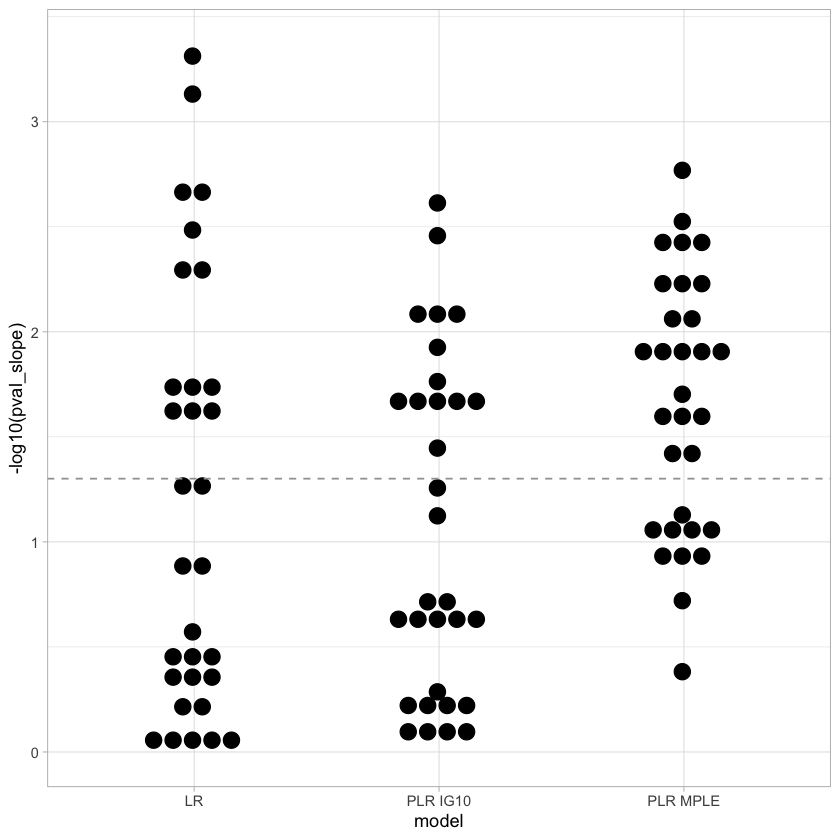

In [9]:
plot_pval=ggplot(data_venn, aes(x=model, y=-log10(pval_slope))) + 
  geom_dotplot(binaxis='y', stackdir='center',stackratio=1.2, dotsize=0.7)+
  theme_light() +
  geom_hline(yintercept=-log10(0.05), col='grey63', linetype='dashed')+
ggtitle('Distribution of slope-associated pvalues for the different logistic regression models')

plot_pval



<u>Interpretation</u>:
Here, we display the distribution of slopeassocaited pvalues for eacg different model family (LR, PLR_IG10 and PLR_MPLE)- The p-value is shown as the -log10(pvalue) and anything above the horizontal line that represents -log10(0.05) is a pvalue associated with a significant slope.
LR and PLR IG10 have a braoder distribution than PLR MPLE, yet as seen above in the venn diagramm we obtain more significant slopes from the PLR model.
Significant pvalues from LR models range from: 0.00049 to 0.049
Significant pvalues from PLR_IG10 models range from: 0.0017 to 0.041
Significant pvalues from PLR_MPLe models range from: 0.0024 to 0.035
Top5 analysis below will highlight if the genes assocaited with the most significant pvalues are conserved accross the different model families. 

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



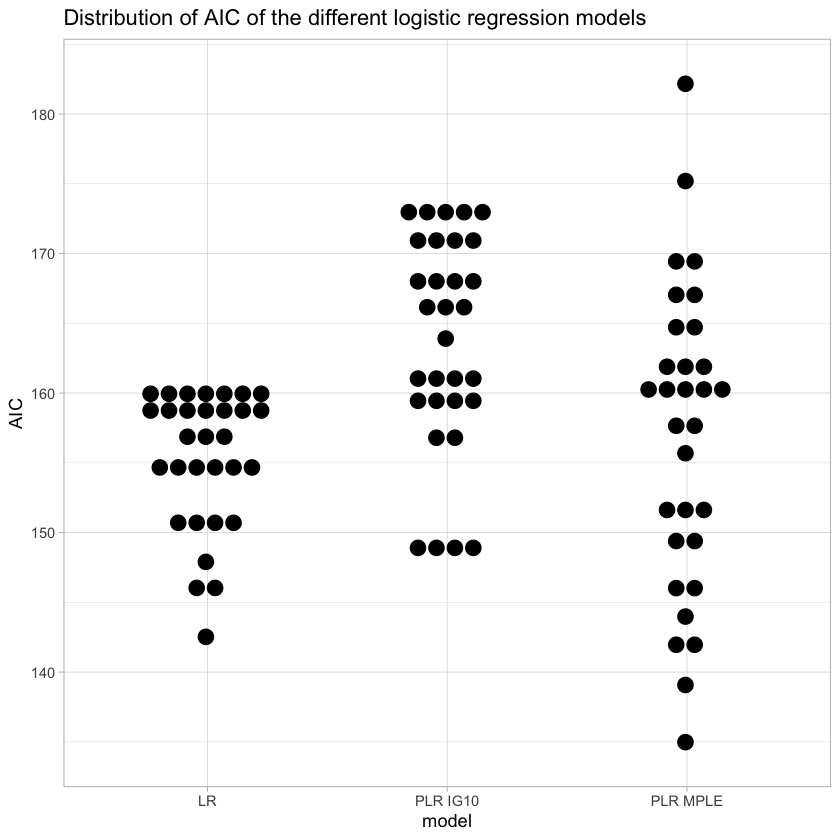

In [11]:
plot_aic=ggplot(data_venn, aes(x=model, y=AIC)) + 
  geom_dotplot(binaxis='y', stackdir='center',stackratio=1.2, dotsize=0.7)+
  theme_light() +
ggtitle('Distribution of AIC of the different logistic regression models')

plot_aic

<u>Interpretation</u>:
Based on AIC values, it looks like LR models have an overall better goodness of fit than the PLR models. Among the two different PLR model famlies, PLR_MPLE, while havinf a broader distribution of AIC, seem to have an overall better AIC score than the PLR_IG10 models.

#### Distribution of pvalues and AIC of the top 5 genes of each model type 

(top 5 means genes with the lowest pvalus)

In [6]:
## We keep only the top 5 genes with each model

# Start by sorting each model by lowest pval_slope to highest

lr_sig=lr_sig[order(lr_sig$pval_slope),]
plr_mple_sig=plr_mple_sig[order(plr_mple_sig$pval_slope),]
plr_ig10_sig=plr_ig10_sig[order(plr_ig10_sig$pval_slope),]

top5=rbind(lr_sig[1:5,],plr_mple_sig[1:5,])
top5=rbind(top5, plr_ig10_sig[1:5,])


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



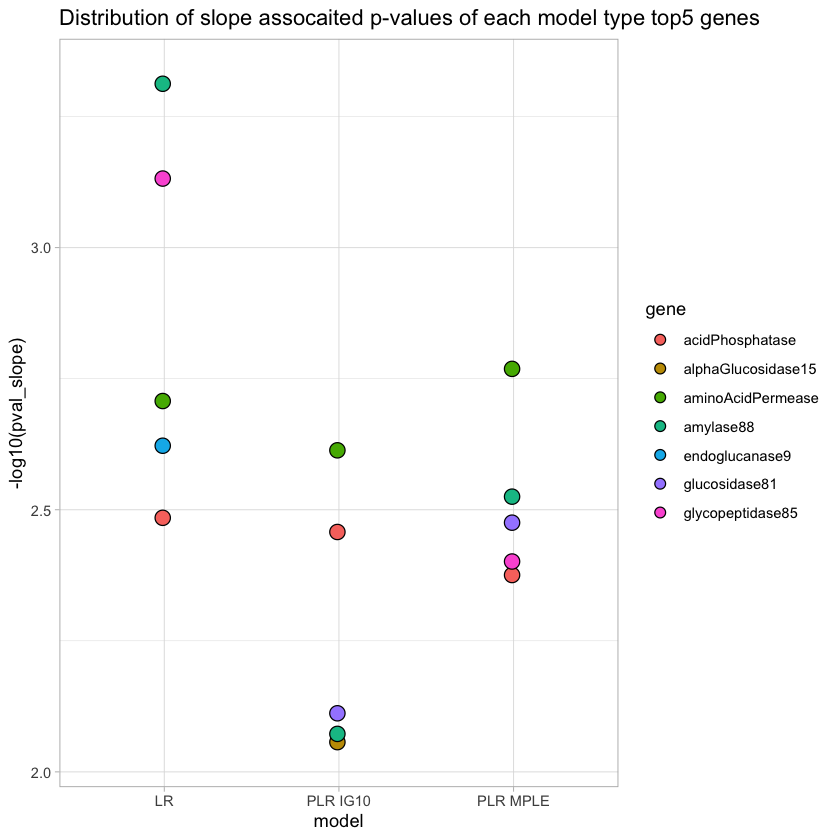

In [7]:
#Pvalues plot
plot_pval_top5=ggplot(top5, aes(x=model, y=-log10(pval_slope), fill=gene)) + 
  geom_dotplot(binaxis='y', stackdir='center',stackratio=1.2, dotsize=0.7)+
  theme_light() + ggtitle('Distribution of slope assocaited p-values of each model type top5 genes')

plot_pval_top5



<u>Description/Interpretation</u>:

- Top 5 of each model family slightly differ but 3 shared genes among all (acidPhosphatase, amino acid permease, amylase)
- Rank of these 3 shared genes is not conserved based on model family
- 2 genes are shared in the top 5 of two model families (glucosidase (PLR models), glycopeptidase(PLR_MPLE & LR))
- 2 genes are in the top5 of a single model family (endoglucanase(LR), alpha-glucosidase(PLR_IG10)) 

So, overall the top 5 genes identified by each logistic regression model family are conserved for 50%. 

*Acid phosphatases* are a class of diverse enzymes that catalyse the cleavage of phospho-monoester bonds in. organophosphate compound. Fungal acidphosphatase have an important role in mobilizing phosphate in mycorrhizal relationship, also acidphosphatase produces and released in the soil by fungi increase the amount of available phosphate for the local plant. 
*Amino acid permeases* are membrane permeases the allow the transport of amino acids into the cell. They allow fungi to exploit organic nitrogen sources. Such ability might be criticial for niche occupation as well as for biotic interactions.
*Amylases* are enzymes that catalyse the hydrolysis of starch into sugars and allow fungi to access carbon through starch digestion.

So, these 3 enzymes are be directly connected (not part of the same metabolic pathway and maybe even trophic mode), yet they all contribute to fungal metabolism and access to nutrient. However, it is still challenging at this point to conclude or even make an hypothesis about a potential role of FSA considering these 3 genes being a predictor of the FSA status.  


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



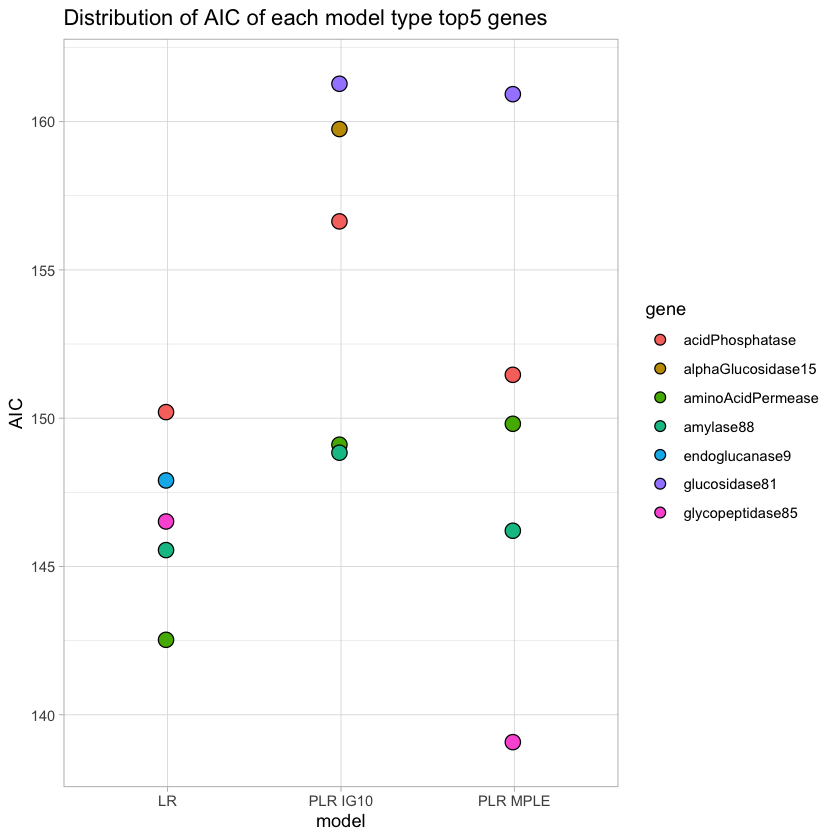

In [8]:
#Aic plot
plot_aic_top5=ggplot(top5, aes(x=model, y=AIC, fill=gene)) + 
  geom_dotplot(binaxis='y', stackdir='center',stackratio=1.2, dotsize=0.7)+
  theme_light() + ggtitle('Distribution of AIC of each model type top5 genes')

plot_aic_top5

<u>Description/Interpretation</u>:

Similarly to the previsou AIC plot, overall LR models have a better AIC than the PLR models. Among the PLR models, the PLR_MPLE models have a better AIC than the PLR_IG10

#### **Conclusions / Take home**: 

- We are able to model FSA status using continous predictors and taking phylogeny into account.

- While regular LR seem to generate better goodness of fit, taking into account phylogeny should be the best choice. In PLR models, the MPLE family, while generating a less broad distribution of p-values, is associated woth better goodness of fit compared to IG10 family models.

- Because different model families led to different pvalues ranges and various AIC (and also becasue we didn't do any correction for multiple comparison yet), we investigated whether there is still a consistent message from these different models by comparing the top 5 results. In the top results, 3 genes stood out as consistent predictors of FSA status. Yet their biological roles are pretty well distinct and not closely connected making it challenging to obtain a clear message.

*Notes/Thoughts*:

- Additional test of correlation with simple presence/absence test will be useful to complement/validate or invalidate these results
- No data transformation has been performed - should that be considered?

---

### Spore data

**Hypothesis**

Here we have 4 traits associated with spore data
- fruiting body size (mm2)
- spore length (um)
- spore width (um)
- spore size (no unit)

Running logistic regression for each of these traits, we are testing if any of these spore parameter is a predictor of the FSA status for fungal species. 

**Interpretation of the coefficients**

For each trait, the model returns 2 coefficients:
    - the intercept: here corresponds to the log odds of the FSA status to be 1 when there the trait equals 0 => here, the intercept does not make any sense.
    - predictor (spore size, spore width, fruitong body size or spore length) effect (slope): average increase of the log odds of the FSA status to be 1 when the trait increases of 1 unit.

1- When none of the coefficient are significant or when the intercept only is significant, the model indicates that there is no effect of the predictor on the FSA status

2- When the slope is significant, this indicates that the trait is a significant predictor of the response (but potentially can be very weak)

**Biological interpretation if 1 spore data is predictive of FSA status**

Fungal spores are essential structures for fungal sexual reproduction as well as resistance to stress. A correlation between spore parameter and FSA status could potentailly highligth some implication of FSA in spore morphology, integrity, or formation or an implication in fungal sexual reproduction.


**LR and PLR Models goodnessof fit evaluation and comparison**

Here again, we are trying two different regressions for each trait, and we eventually evaluate and compare how each model (LR versus PLR) performs using AIC. 

*Notes*:
  - *this dataset is restricted to a single phylum: Basidiomycota*


In [112]:
df_results_models_spores=model_result_sum_table(results_spore_traits)
df_results_models_spores

trait,model,intercept,pval_interp,slope,pval_slope,AIC
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
spore_size _ lr,LR,1.324316,0.02014110,3.038319e-07,0.7205309,23.80565
spore_size _ plr,PLR,1.142870,0.06238954,3.038319e-07,0.6995674,24.90790
spore_size _ plr_IG10,PLR,1.324316,0.04047364,3.038319e-07,0.7216965,25.12773
spore_length _ lr,LR,1.563176,0.01780852,-4.915629e-03,0.5620243,23.70275
spore_length _ plr,PLR,1.563073,0.39537708,-1.021536e-02,0.4065676,36.42801
spore_length _ plr_IG10,PLR,1.563176,0.03724768,-4.915629e-03,0.5725524,25.12853
spore_width _ lr,LR,1.364600,0.02696049,9.458085e-04,0.9356874,24.00937
spore_width _ plr,PLR,1.363842,0.48005816,7.374335e-03,0.7347313,32.56594
spore_width _ plr_IG10,PLR,1.364600,0.05415009,9.458085e-04,0.9367844,25.50112


#### Data interpretation / summary 

**Coefficient analysis**

None of the models identify a significant slope for any spore trait
Thus, it appears that neither, spore length, width, size nor fruiting size is a predictor of FSA status

**Model goodness of fit comparison**

Comparing AIC values for LR models always present a better fit.

*Note: we only had data for 17 species in that dataset, 14 of them had FSA.

---

### Tissue composition (carbon, nitrogen and phosphorus)

**Hypothesis**

Here we are testing whether carbon composition, nitrogen compoistion or phophorus composition (each one independently) are predictors of fungal species FSA status.

**Biological interpretation of when a gene copy number is a significant predictor of FSA status**

C, N and P composition can be representative of ressource acquisition and physiology and could play a more global roles in biogeochemical cycling. For instance, for mycorrhizal fungi, provide 80% of plant N and P. Maybe, a correlation between C, N or P content with FSA status could be an indicator of the FSA implication in specific ecology/fungal guild or in these chemicals uptake and distribution. 


**Interpretation of the coefficients**

The model returns 2 coefficients:
    - the intercept: here corresponds to the log odds of the FSA status to be 1 when there is no C, N or P - an significant intercept has no relevence as any of these 3 chemicals is essential.
    - predictor (gene copy) effect (slope): average increase of the log odds of the FSA status to be 1 when C,N or P concentration increases of 1 unit.

1- When none of the coefficient are significant  or only the intercept is significant, the model indicates that there is no effect of the predictor on the FSA status

2- When the slope is significant, this indicates that the trait is a significant predictor of the response (but potentially can be very weak)


**LR and PLR Models goodnessof fit evaluation and comparison**

Again, we are using the AIC index to compare the models goodnes of fit

*Notes: *while individual compositions are available, sometimes chemicals ratios can be more informative of the important biology - these ratio information is available from the same paper but span a lower number of species.*

In [119]:
df_results_models_tissueC=model_result_sum_table(TisC_results)
df_results_models_tissueC

trait,model,intercept,pval_interp,slope,pval_slope,AIC
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TisC _ lr,LR,14.20855,0.3356296,-0.3159834,0.3465441,71.05067
TisC _ plr,PLR,14.45705,0.3211201,-0.3165129,0.3392247,75.56611
TisC _ plr _ IG10,PLR,14.20850,0.3270362,-0.3179893,0.3349476,74.50384


In [120]:
df_results_models_tissueN=model_result_sum_table(TisN_results)
df_results_models_tissueN

trait,model,intercept,pval_interp,slope,pval_slope,AIC
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TisN _ lr,LR,2.506596,0.02871803,-0.4856299,0.05344075,40.84865
TisN _ plr,PLR,2.011487,0.05249014,-0.4064785,0.07765710,40.61728
TisN _ plr _ IG10,PLR,2.102540,0.04645510,-0.4360287,0.06360605,40.63192


In [121]:
df_results_models_tissueP=model_result_sum_table(TisP_results)
df_results_models_tissueP

trait,model,intercept,pval_interp,slope,pval_slope,AIC
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TisP _ lr,LR,0.48781719,0.4644539,-0.4609201,0.5677347,57.50378
TisP _ plr,PLR,-0.08320593,0.9150964,-1.1588461,0.2827881,72.14043
TisP _ plr _ IG10,PLR,0.22630955,0.7303187,-0.1601215,0.8374285,63.06292


#### Data interpretation / summary 

**Coefficient analysis**

None of the models identify a significant slope for any composition
Thus, it appears that neither, c composition, n composition nor p composition is a predictor of FSA status

**Model goodness of fit comparison**

Comparing AIC values for LR models are a better fir most of the time

*Note: we only had data for 17 species in that dataset, 14 of them had FSA.

---

### Melanin content

**Hypothesis**

Here we are testing whether melanin is a predictor of fungal species FSA status.

**Biological interpretation of when a gene copy number is a significant predictor of FSA status**

Melaninis typically located in the cell wall of fungal species, and its distribution varies among species. Sometimes refered to as 'fungal armor', melanin is expecetd to protect fungi in harsh environmenet and against multiple toxins.It is also assocaited with fungal pathogenicity. A correlation between melanin composition and FSA status could highlight some implication of FSA in pathogenicity mechanisms or resistance to stress, or maybe some direct interaction with melanin distribution.


**Interpretation of the coefficients**
The model returns 2 coefficients:
    - the intercept: here corresponds to the log odds of the FSA status to be 1 when there is no melanin.
    - predictor (gene copy) effect (slope): average increase of the log odds of the FSA status to be 1 when melanin content increases of 1 unit.

1- When none of the coefficient are significant  or only the intercept is significant, the model indicates that there is no effect of the melanin content on the FSA status
2- When the slope is significant, this indicates that the trait is a significant predictor of the response (but potentially can be very weak)


**LR and PLR Models goodnessof fit evaluation and comparison**

Again, we are using the AIC index to compare the models goodnes of fit

In [122]:
df_results_models_Mel=model_result_sum_table(Mel_results)
df_results_models_Mel

trait,model,intercept,pval_interp,slope,pval_slope,AIC
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mel _ lr,LR,1.012700,0.1841107,0.0008764614,0.8875225,30.97176
Mel _ plr,PLR,1.012639,0.3984024,-0.0052116252,0.2568909,38.90239
Mel _ plr _ IG10,PLR,1.012700,0.1849705,0.0008764614,0.8874448,33.11456


#### Data interpretation / summary 

**Coefficient analysis**

None of the models identify a significant slope for melanin as a predictor of FSA status

**Model goodness of fit comparison**

Comparing AIC values for LR model is a better fit.

---


### Extension rate

**Hypothesis**

Here we are testing whether the fungi extension rate is a predictor of fungal species FSA status.

**Biological interpretation of when a gene copy number is a significant predictor of FSA status**

Extension rate represents the speed the hyphae part of the fungi grow. A correlation between FSA status and extension rate could highlight the implication of this specific actin in fungal hyphael growth/apic growth. This could be expected as regular actin is known to be important for fungal growth

**Interpretation of the coefficients**
The model returns 2 coefficients:
    - the intercept: here corresponds to the log odds of the FSA status to be 1 when there is no growth 
    - predictor (gene copy) effect (slope): average increase of the log odds of the FSA status to be 1 when the extension rate increases of 1 unit.

1- When none of the coefficient are significant  or only the intercept is significant, the model indicates that there is no effect of the extension rate on the FSA status
2- When the slope is significant, this indicates that the trait is a significant predictor of the response (but potentially can be very weak)


**LR and PLR Models goodnessof fit evaluation and comparison**

Again, we are using the AIC index to compare the models goodnes of fit

In [123]:
df_results_models_ExR=model_result_sum_table(ExR_results)
df_results_models_ExR

trait,model,intercept,pval_interp,slope,pval_slope,AIC
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ExtR _ lr,LR,0.9784320,0.3853798,-0.06250174,0.5931904,21.03323
ExtR _ plr,PLR,1.8397141,0.2114138,-0.19753761,0.1776956,25.62745
ExtR _ plr _ IG10,PLR,0.5601014,0.6076406,-0.01597195,0.8924076,24.70474


#### Data interpretation / summary 

**Coefficient analysis**

None of the models identify a significant slope for extension rate as a predictor of FSA status

**Model goodness of fit comparison**

Comparing AIC values for LR model is a better fit.

---